In [2]:
import pandas as pd
import numpy as np
#import statsmodels.api as sm
from statsmodels.stats import multitest
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from cycler import cycler
import os
import itertools
import seaborn as sns
import ratmetab
import warnings
warnings.filterwarnings('ignore')

In [7]:
codebookpath = '../RatMetabolites/Rat_codebook_27_Oct_2022.csv'
data = ratmetab.read_all_data()
data['brain']

,2-Hydroxyacylceramide C12:0,2-Hydroxyacylceramide C14:0,2-Hydroxyacylceramide C20:0,2-Hydroxyacyldihydroceramide C28:0,"24,25-Dihydrolanosterol","24,25-Epoxycholesterol",24S-Hydroxycholesterol,27-Hydroxycholesterol,4-beta-Hydroxycholesterol,"5-alpha,6-alpha-Epoxycholesterol",...,Threonine,Tryptophan,Tyrosine,Vaccenic acid,Valerylcarnitine,Valine,alpha-Aminoadipic acid,beta-Muricholic acid,gamma-Linolenic acid,trans-4-Hydroxyproline
idno,,,,,,,,,,,,,,,,,,,,,
105,0.000969,0.002056,NaN,NaN,59.5312,52.3034,10305.0,209.800,349.2,NaN,...,636.755,29.050,109.309,142.076,0.033825,77.492,9.779,NaN,2.7892,13.256
1158,0.004649,0.002526,NaN,NaN,55.4256,54.5004,11765.0,258.700,454.0,NaN,...,628.067,35.743,80.224,127.932,0.068129,77.561,7.766,NaN,3.0140,6.932
1172,NaN,NaN,NaN,NaN,72.1218,62.7215,9941.0,300.600,424.2,NaN,...,631.976,28.480,93.248,142.456,0.066152,63.230,7.402,NaN,NaN,6.320
1174,0.003403,0.001267,NaN,NaN,74.1746,43.1609,9576.0,243.700,719.5,NaN,...,580.128,25.383,59.085,126.200,0.132000,64.286,5.895,NaN,2.8104,6.719
127,0.002475,NaN,NaN,NaN,70.0690,41.9561,8719.0,224.700,766.6,NaN,...,612.102,22.570,75.165,178.604,0.062654,87.566,5.479,NaN,2.9756,9.918
1368,0.004245,NaN,NaN,NaN,62.5420,55.9178,9941.0,239.700,495.4,1.1155,...,737.039,22.079,77.438,127.072,0.051299,74.226,9.346,NaN,2.8568,4.786
1416,0.004853,0.004054,NaN,NaN,54.7414,49.1850,9941.0,216.700,650.2,NaN,...,689.327,25.157,80.146,137.340,0.071780,73.736,6.791,NaN,2.8072,9.623
1424,0.000495,NaN,NaN,NaN,45.7091,63.3594,9019.0,200.800,519.4,2.9557,...,984.415,35.350,118.435,125.408,0.488000,154.607,12.144,NaN,3.0916,19.336
143,0.005857,0.003247,NaN,NaN,68.4267,27.4983,8545.0,209.800,660.8,NaN,...,895.900,33.390,65.174,149.232,0.070783,66.650,9.424,NaN,3.3784,28.765


In [9]:
codebookpath = '../RatMetabolites/Rat_codebook_27_Oct_2022.csv'
datapath = {
    'blood new': 'blood_27_Oct_2022',
    'brain new': 'brain_27_Oct_2022',
    'blood old': 'old_blood_17_Nov_2022',
    'brain old': 'old_brain_17_Nov_2022',
            }
excluded_metabolites = {k: ratmetab.read_data('../RatMetabolites/Rat_' + v + '.csv', codebookpath, liberal_filter=True, return_m2exclude=True) for k, v in datapath.items()}
excluded_metabolites_cons = {k: ratmetab.read_data('../RatMetabolites/Rat_' + v + '.csv', codebookpath, liberal_filter=False, return_m2exclude=True) for k, v in datapath.items()}

excluded_metabolites.update({tissue: set(excluded_metabolites[tissue + ' new']).intersection(set(excluded_metabolites[tissue + ' old'])) for tissue in ['blood', 'brain']})
excluded_metabolites_cons.update({tissue: set(excluded_metabolites_cons[tissue + ' new']).intersection(set(excluded_metabolites_cons[tissue + ' old'])) for tissue in ['blood', 'brain']})

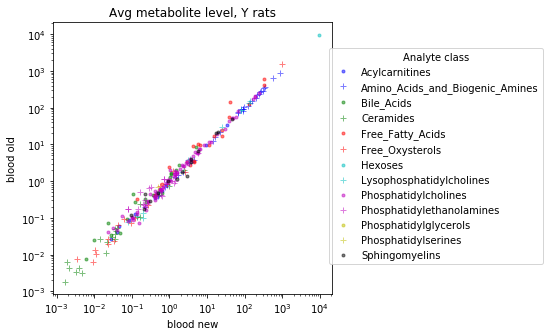

In [11]:
def take1avg(metabolite, group, dataset, data=data):
    df = data[dataset]
    res = df.loc[df.Group == group, metabolite].mean()
    return(res)

def take_all_avgs(group, dataset, data=data):
    l = [take1avg(metabolite, group, dataset, data=data) for metabolite in data[dataset].columns[2:]]
    s = pd.Series(l, index=data[dataset].columns[2:])
    return(s)

def avg_metab_scatter(group, datasetA, datasetB, data=data):
    l = [take_all_avgs(group, dataset, data=data) for dataset in [datasetA, datasetB]]
    df = pd.concat(l, axis=1, join='inner')
    df.columns = [datasetA, datasetB]
    return(df)

def avg_metab_scatter_plot(group, datasetA, datasetB, data=data, codebookpath=codebookpath):
    codebook = pd.read_csv(codebookpath, index_col='MetaboliteName')
    df = avg_metab_scatter(group, datasetA, datasetB, data=data)
    df = pd.concat([df, codebook.AnalyteClass], axis=1)
    fig, ax = plt.subplots(figsize=(5, 5))
    my_cycler = (cycler(color=list('bgrcmyk')) * cycler(marker=['.', '+']))
    ax.set_prop_cycle(my_cycler)
    ax.set_xlabel(datasetA)
    ax.set_ylabel(datasetB)
    ax.set_title('Avg metabolite level, ' + group + ' rats')
    #ax.axline((0, 0), slope=1, linewidth=1, linestyle='dotted', color='black')
    for aclass in np.unique(df.AnalyteClass):
        clsdata = df.loc[df.AnalyteClass == aclass]
        ax.plot(clsdata[datasetA], clsdata[datasetB], label=aclass, alpha=0.5, linestyle = '')
        #ax.scatter(x=datasetA, y=datasetB, data=clsdata, label=aclass)
    ax.set_xscale('log')
    ax.set_yscale('log')
    fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5), title='Analyte class')
    return((fig, ax))


fig, ax = avg_metab_scatter_plot('Y', 'blood new', 'blood old')

In [12]:
def extract2groups(metabolite, groupA='AU', groupB='AI', df=data['blood new']):
    l = [df.loc[df.Group == g, metabolite].dropna() for g in [groupA, groupB]]
    return(l)

def get_log_p(A, B):
    val = - np.log10(stats.ttest_ind(A, B)[1])
    return(val)

def get_effect_size(A, B):
    '''
    The effect size x is B relative to A, so if A > B => x < 0
    '''
    #val = B.mean() - A.mean() # the original definition; does not normalize effect size!
    OR = B.mean() / A.mean()
    log2OR = np.log2(OR)
    return(log2OR)

def get_both(metabolite, groupA='AU', groupB='AI', df=data['blood new']):
    A, B = extract2groups(metabolite, groupA, groupB, df)
    log_p = get_log_p(A, B)
    fx_size = get_effect_size(A, B)
    return((fx_size, log_p))

def get_both_all(groupA='AU', groupB='AI', df=data['blood new']):
     metabolites = df.columns[2:]
     l = [get_both(m, groupA, groupB, df) for m in metabolites]
     fx_sizes = [x[0] for x in l]
     log_ps = [x[1] for x in l]
     return((fx_sizes, log_ps))

In [13]:
comparisons = {
    'AI vs. AU': ['AU', 'AI'],
    'AI vs. Y': ['Y', 'AI'],
    'AU vs. Y': ['Y', 'AU'],
              }
results = {d: {k: get_both_all(*v, df=data[d]) for k, v in comparisons.items()} for d in data.keys()}

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [ ]:
def writeResults(dataset='brain new', comparison='AI vs. AU', alpha=0.05, method='fdr_bh', data=data, results=results):
    dat = data[dataset]
    codebook = pd.read_csv(codebookpath, index_col='MetaboliteName')
    metabolites = dat.columns[2:]
    metab_class = codebook.loc[metabolites, 'AnalyteClass']
    res = results[dataset]
    t = res[comparison]
    direction = ['Increase' if x>0 else 'Decrease' for x in t[0]]
    pvals = 10 ** (-np.array(t[1]))
    reject, pvals_corrected, alphacSidak, alphacBonf = multitest.multipletests(pvals, alpha=alpha, method=method)
    df = pd.DataFrame({'Dataset':dataset, 'Comparison': comparison,
                       'Analyte class': metab_class, 'Metabolite': metabolites,
                       'Effect size':t[0],'"- log p"':t[1], 'p': pvals,
                       r'Corrected p': pvals_corrected,
                       r'Reject H0': reject,
                       r'Bonferroni alpha': alphacBonf,
                       'Direction of change': direction})
    df = df.sort_values('Effect size')
    df = df.sort_values('p')
    df['Rank'] = np.arange(len(df)) + 1
    return(df)

In [ ]:
def get_summary(data, results, liberal_only=False):
    def helper(df, dataset, liberal_only=liberal_only):
        if not liberal_only:
            return(df)
        rows = set(excluded_metabolites_cons[dataset]).difference(set(excluded_metabolites[dataset]))
        return(df.loc[rows])
    ll = [[helper(writeResults(dataset=d, comparison=c), d, liberal_only) for c in comparisons.keys()] for d in data.keys()]
    #ll = [[writeResults(dataset=d, comparison=c) for c in comparisons.keys()] for d in data.keys()]
    l = itertools.chain(*ll)
    summary = pd.concat(l)
    return(summary)

summary = get_summary(data=data, results=results)
summary_lib_only = get_summary(data=data, results=results, liberal_only=True)